## Final Prediction Ablation

After running parameter prediction studies for 3,4,5, and 6 member communities, this script will compare the final testing error across all communites to see how prediction error bifurcates with both embedding dimension and community size. In order for this script to run, a set of fully trained MLP-VAE decoder models must have already been trained for each community of interest at embedding dimensions of prespecified fidelity. Such a dataset can be generated by first generating a series of VAEs from the `run_sim_compression_experiment.py` script and then training MLPs into the latent space via `run_sim_predict_experiment.py` scripts. We provide the trained models used in the figure in the repo. 

We start by importing the requisite libraries: 

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F

device = "cuda:0"

In [9]:
from sklearn.model_selection import train_test_split 

Here we quickly redefine our `EncoderMap` NN model to enable importing trained networks with this structure for ablation study analysis. Since it's so small, we can quickly redefine it here instead of transferring it to a seperate file. 

In [10]:
class EncoderMap(torch.nn.Module):
    
    def __init__(self, base_model, B, C, L):
        super().__init__()
        
        n = in_dim
        layer_size = max(n*(n+1), 10)
        
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear( (n*(n+1)) ,layer_size),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(layer_size,layer_size),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(layer_size,layer_size),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(layer_size,layer_size),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(layer_size,layer_size),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(layer_size, em_dim)
        )
        
        self.linear2 = base_model.linear2.eval()
        self.decoder = base_model.decoder.eval()
    
                
        # Get the dimensionf othe precode
        self.B = B
        self.C = C
        self.L = L
        
    def forward(self, X, ):
        
        B = X.shape[0]
        code = self.mlp(X)
        post_code = self.linear2(code)
        post_code = post_code.view(B,self.C,self.L)
        X_hat = self.decoder(post_code)
        
        return X_hat

To pull the data used for the study, we define a `gen_data` function which will take the original data files as input and output the training data and parameter labels for a community of specified size `in_dim` ($ = N$).

In [11]:
def gen_data(in_dim):
    file_name = f"data/param_space_{in_dim}_3.npy"
    data = np.load(file_name)
    X = torch.Tensor(data).to(device).double()

    file_name = f"data/param_space_{in_dim}_3_labels.npy"
    data = np.load(file_name)
    Y = torch.Tensor(data).to(device).double()

    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,  test_size = 0.25, random_state = 42)
    
    return X_train, X_test, Y_train, Y_test

Now lastly we perform the bifurcation analysis shown in figure 6C:

torch.Size([2500, 3, 20])
torch.Size([2500, 4, 20])
torch.Size([2500, 5, 20])
torch.Size([2500, 6, 20])


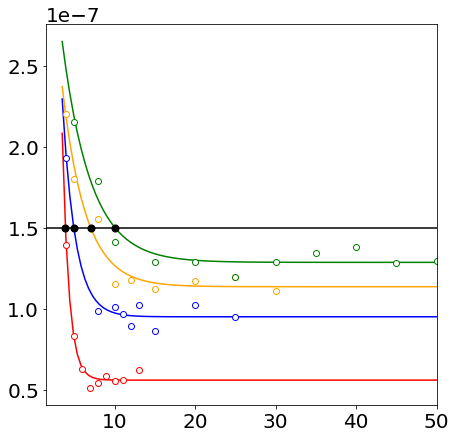

In [12]:
from scipy.optimize import curve_fit

# Here we specify the embedding dimensions for each communtity for which VAEs were trained. Each row corresponds to a different 
# community size starting from N = 3, then 4,5,6.
em_dims_big = [[4,5,6,7,8,9,10,11,13, ],
               [4,5,8,10,11, 12,13,15,20,25,],
               [4,5,8,10,12,15,20,25, 30 ],
               [5,8,10,15,20,25,30,35,40,45,50]]

colors = ["red", "blue","orange","green"]

plt.figure(figsize = (7,7))

def func(x, a, b, c,):
    return a * np.exp(-b * x) - c

x_stars = []
in_dims = [3,4,5,6]
for in_dim in in_dims:
    errors = []
    X_train, X_test, Y_train, Y_test = gen_data(in_dim)
    print(X_test.shape)
    em_dims = em_dims_big[in_dim-3]
    color = colors[in_dim-3]
    for em_dim in em_dims:
        
        
        device = "cuda:0"

        file_name = f"./saved_models/{in_dim}_FINAL_member_predict_study_{em_dim}/model.pt"
        model = torch.load(file_name).to(device).double()
        #print(model)

        predict  = model(Y_test) # , _, _, _ 
        mean_norm = torch.mean(torch.linalg.norm(X_test)**2)
        

        error = F.mse_loss(X_test, predict)/mean_norm
        errors.append(error.detach().cpu())

    errors = np.array(errors)
        
    # Fit an exponential curve to the dataset.
    popt, pcov = curve_fit(func, em_dims, errors, maxfev=5000)
    x = np.linspace(3.5,50,100)

    a, b, c, = popt

    plt.rc('xtick', labelsize=20) 
    plt.rc('ytick', labelsize=20) 
    plt.xlim(1.5,50)
    
    pred = func(x, a,b,c,)
    
    # Compute embedding dimension of specfiic prespecified fidelity. 
    y_star = 1.5e-7
    x_star = (-1.0/b)*np.log( (y_star + c)/a )
    x_stars.append(x_star)
    plt.scatter(x_star, y_star, color = "k", s = 50, zorder = 3)

        
    plt.plot(x, pred, "-", color = color, label = in_dim)
    plt.scatter(em_dims,errors, edgecolor = color, color = "w", zorder = 2)
    
plt.hlines(1.5e-7,0,53, color = "k")
plt.show()

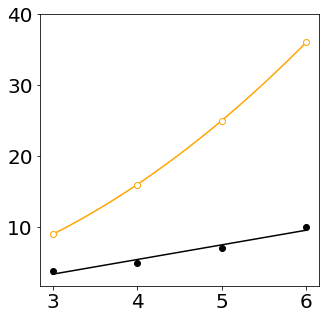

In [13]:
from scipy import stats

plt.figure(figsize = (5,5))
plt.scatter(in_dims, x_stars, edgecolor = "k", c = "k", zorder =3 )
in_dims = np.array(in_dims)
plt.scatter(in_dims,in_dims**2 , edgecolor= "orange", c = "w", zorder = 3)

x = np.linspace(3,6,100)

slope, intercept, r_value, p_value, std_err = stats.linregress(in_dims, x_stars)
x_stars =np.array(x_stars)
plt.plot(in_dims, slope*in_dims + intercept, color = "k")

plt.plot(x,x**2, c = "orange" )
plt.yticks([10,20,30,40])
plt.show()